## 1. Understanding the problem.
From the project backgroud which required predicting high traffic recipes, since high traffic recipes are not continuous varaibles but categorical, this problem is a classification problem( i.e a supervised machine learning classification problem). Understanding the kind of problem is integral to how our project is executed.

## 2. Data Overview.
The dataset given contains data for each recipe as well as whether there was high traffic or low traffic when the recipe was featured on the home page.The data details is shown below:
![Screenshot (26)](Screenshot%20(26).png)


## 3. Exploratory Data Analysis.
Given the data, we explore the data for analytical purpose to discover trends, and also to prepare the data for our machine learning model.

#### import necessary libraries

In [1]:
##necessary libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,precision_recall_fscore_support



#### Read data


In [2]:
data=pd.read_csv('recipe_site_traffic_2212.csv')

#### Data exploration

In [3]:
#check shape
data.shape

(947, 8)

the data has 947 rows(observations) and 8 columns, each row represents a particular recipe.

In [4]:
#check first 5 rows
data.head(5)

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [5]:
#check data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


three of the columns are categorical, while the remaining five are numeric.the recipe column serves as identifier and the high_traffic column is our target column that we are trying to predict.from the data information displayed,some columns have null values and this will be resolved.

In [6]:
#check for null values
data.isna().sum()

recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64

the calories,carbohydrate,sugar,protein columns all have 52 missing values each, while the high_traffic column has 373 missing values.the high_traffic column only contains record of high_traffic and so the missing values are the low traffic that were not recorded and as such, the missing value will imputed as low traffic. For the remaining columns(calories,carbohydrate,sugar,protein), the missing values will be imputed with the median values of the columns based on each category group.

In [7]:
#impute missing values in high_traffic column
data['high_traffic'].fillna('Low',inplace=True)

since missing values in high traffic columns has been imputed, the column will be rename to traffic which is an appropriate name since the column now contains both high and low traffic values

In [8]:
data=data.rename(columns={'high_traffic':'traffic'})

In [9]:
#imputate missing values in calories,carbohydrate,sugar,protein columns with median of category group 
features=['calories', 'carbohydrate', 'sugar', 'protein']
for i in features:
   data[i] = data.groupby(['category'])[i].apply(lambda x: round(x.fillna(x.median()),2))



Median was used for imputation as it is less sensitive to outliers as opposed to the mean. for each category, missing values in (calories,carbohydrate,sugar,protein) are imputed with median value of that column based on the category.


In [10]:
#validate null removal
data.isna().sum()

recipe          0
calories        0
carbohydrate    0
sugar           0
protein         0
category        0
servings        0
traffic         0
dtype: int64

All the missing values have been handled.

In [11]:
#check for duplicates
data.duplicated().sum()

0

There are no duplicates in this data.


In [12]:
#check servings column
data['servings'].unique()

array(['6', '4', '1', '2', '4 as a snack', '6 as a snack'], dtype=object)

the servings column has a mixture of strings and numbers embedded in strings. The column ought to be numerical, and values of '4 as a snack', '6 as a snack' will be changed to 4 and 6 respectively as the initial values represents naming error or mistake. the data type of the column will be changed from object to integer also.

In [13]:
#cleaning servings column
data['servings']=data['servings'].str.strip('as a snack')
#convert the datatype to numeric
data['servings']=data['servings'].astype('int64')
#validate cleaning of servings column
print('data type of servings column-',data['servings'].dtype)
print('Unique values in servings column-',data['servings'].unique())

data type of servings column- int64
Unique values in servings column- [6 4 1 2]


In [14]:
#check category column
data['category'].unique()

array(['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal',
       'Chicken Breast', 'Lunch/Snacks', 'Chicken', 'Vegetable', 'Meat',
       'Dessert'], dtype=object)

Everything looks normal with the category column

#### histogram of each numerical variables

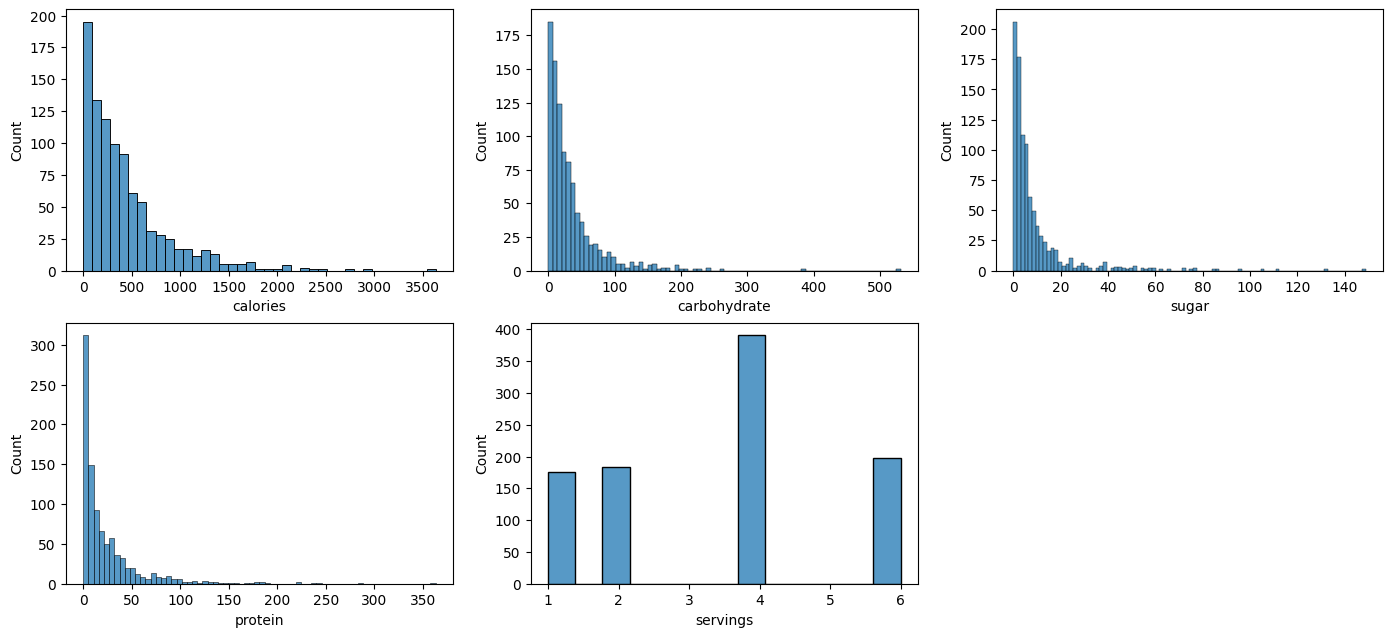

In [15]:
num_columns=['calories', 'carbohydrate', 'sugar', 'protein', 'servings']
plt.figure(figsize=(17,40), facecolor='white')
plotnumber =1
for col in num_columns:
      ax = plt.subplot(10,3,plotnumber)
      sns.histplot(x=data[col])
      plt.xlabel(col)
      plotnumber+=1
plt.show()

calories, carbohydrates, sugar, protein are all heavily skewed to right,this indicates presence of outliers too. however servings is approximately normal.for calories, most recipes, have calories less than 1000, for carnohydrates, most recipes have carbohydrates less than 100units while for sugar and protein ,most of the values are less than 50 and 100 respectively. recipes with 4 servings occur the most in this data.

#### bar plot of categorical variables

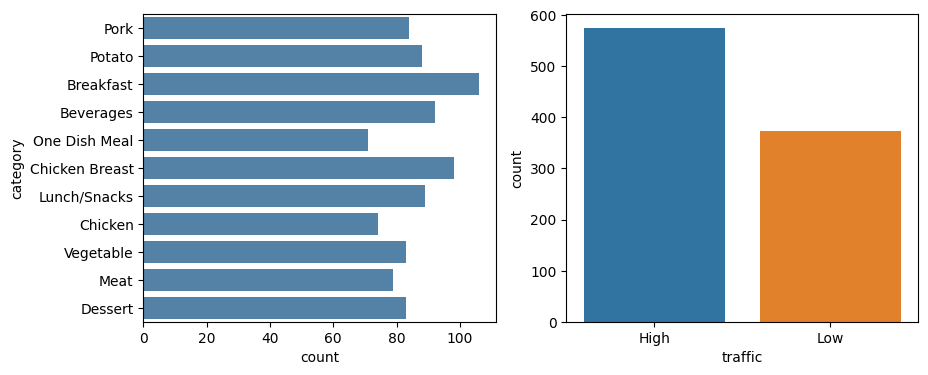

In [16]:
cat_columns=['category','traffic']
fig,ax=plt.subplots(1,2,figsize=(10,4))
sns.countplot(data=data,y='category',ax=ax[0],color='steelblue')
sns.countplot(data=data,x='traffic',ax=ax[1])
plt.show()

in the catgeory column,recipes that are breakfast occured more than anyother. one dish meal has the lowest occurence of all the recipe categories. in traffic column,there are more high traffic recipes than low traffic recipes.

#### check for outliers

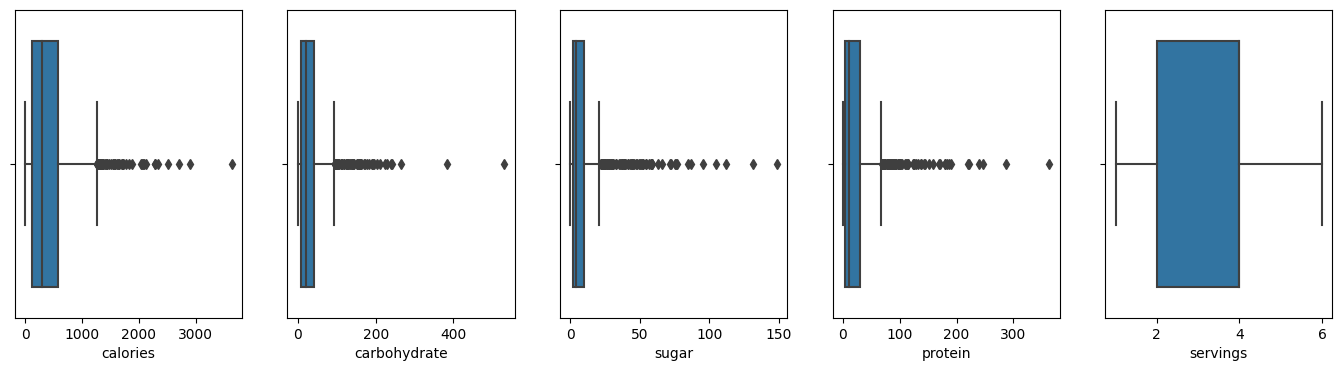

In [17]:
#check for outliers 
fig,ax=plt.subplots(1,5,figsize=(17,4))
for i in num_columns:
  sns.boxplot(x=data[i],ax=ax[num_columns.index(i)])

there are many outliers in calories,carbohydrate,sugar,protein and they will be capped at maximum value,since we cannot afford to remove them due to limited data

In [18]:
#Winsorizing outliers 
for i  in features:
#setting limits
   q1=data[i].quantile(0.25)
   q3=data[i].quantile(0.75)
   iqr=q3-q1
   lower=q1-(1.5*iqr)
   upper=q3+(1.5*iqr)
#replacing extremes with lower and upper limit
   data[i] = np.where(data[i] <lower, lower,data[i])
   data[i] = np.where(data[i] >upper, upper,data[i])

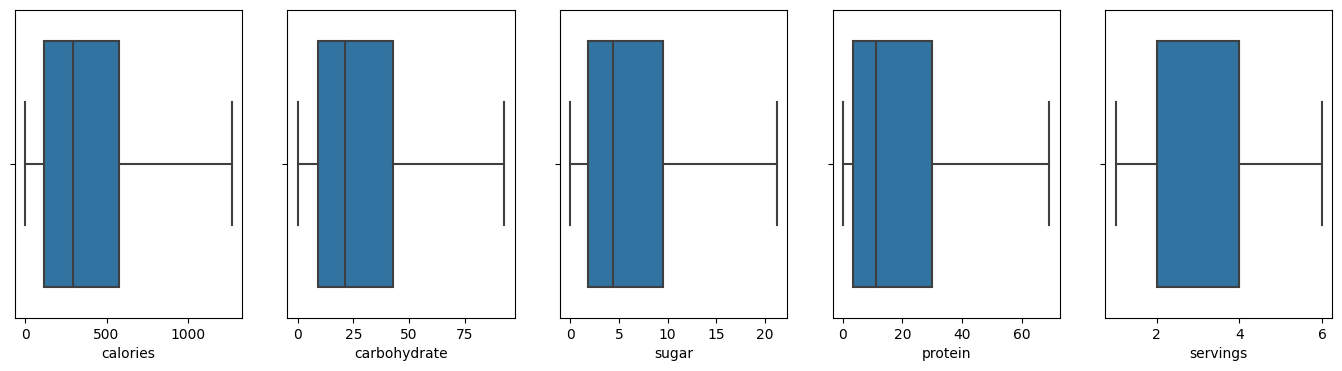

In [19]:
#validate outliers removal
fig,ax=plt.subplots(1,5,figsize=(17,4))
for i in num_columns:
  sns.boxplot(x=data[i],ax=ax[num_columns.index(i)])

The outliers have all been handled.

####  Category and target

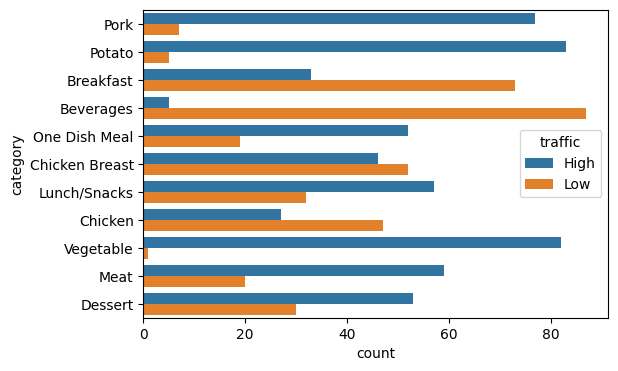

In [20]:
#Visualising category and traffic
plt.figure(figsize=(6,4))
sns.countplot(data=data,y='category',hue='traffic')
plt.show()

From the above plot of category and traffic, it can be seen that recipes containing pork,potato,vegetable and meat led to more high traffic compared to the rest. recipes containing breakfast and beverages significant led to more low traffic.

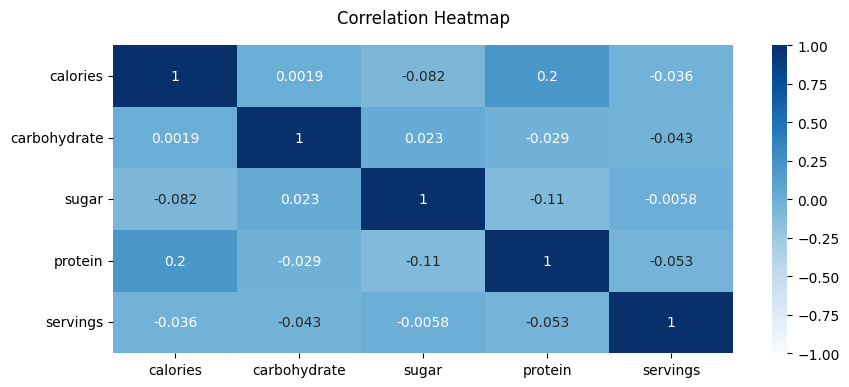

In [21]:
#check for multicolinearity
plt.figure(figsize=(10,4))
corr_df=data.drop(columns=['recipe'],axis=1)
heatmap=sns.heatmap(corr_df.corr(), vmin=-1, vmax=1, annot=True, 
                      cmap='Blues',linecolor='black')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=16)
plt.show()

From the correlation heatmap,none of the columns are correlated with each other and this a good thing as we don't have to worry over multicollinearity affecting our model coffecients.The strongest correlation we have is between protein and calories,however given that the value is 0.2, it is still a weak correlation

## 4.Model Building

Since the problem has been recognised as a classification problem, classification models will be used. However, the business problem requires us to correctly predict high traffic recipes 80% of the time and minimize the chance of low recipe traffic,hence, the evaluation metric that will be used is precision. 

The chosen KPI(or metric) with respect to business goal is precision score of the first class of at least 80%. Precision measures the percentage of predictions made by the model that are correct. The models that will be used will be compared based on their precision and the one with highest precision will be chosen. Using precision as evaluation metric helps our project to be relevant to business need. we will be optimizing the precision of the first class since the first class represents high traffic recipes. The goal is for our model to have precision score that is not less than 80%(this is our chosen KPI)

Two models will be evaluated, which are the logistic regression model and random forest.Logistic regression model serves as baseline model because of its simplisity and interpretability. random forest is an ensemble model that offers better performance in most cases, and it will be compared to the logistic regression model. 

#### Encoding variables

In [22]:
#encoding the target variable
le=LabelEncoder()
data['traffic']=le.fit_transform(data['traffic'])
#encoding category column
data=pd.get_dummies(data,columns=['category'])


#### train test split

In [23]:
#Split data into X and y
X=data.drop(columns=['recipe','traffic'],axis=1)
y=data['traffic']

#train test split
rs=62
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,stratify=y,random_state=rs)


#### feature scaling

In [24]:
#MinMax scaling
scaler=MinMaxScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

#### model selection


In [25]:
#models
LR=LogisticRegression(solver='liblinear',random_state=rs)
RF=RandomForestClassifier(random_state=rs,n_jobs=-1)

In [26]:
#logistic regresion params
C=[(10**i) for i in range(-2,2)]
tol=[(10**i) for i in range(-4,0)]
penalty=['l1','l2','elasticnet']
LR_params={'C':C,'tol':tol,'penalty':penalty}

#random forest params
n_estimators=[100,125,150,200]
max_depth=[3,5,7,9]
min_samples_split=[2,4,6] 
min_samples_leaf=[1,3,5]
RF_params={'n_estimators':n_estimators,'max_depth':max_depth,
          'min_samples_split':min_samples_split,'min_samples_leaf':min_samples_leaf}

#custom scorer
from sklearn.metrics import fbeta_score
c_scoring = {"accuracy": 'accuracy',
    "precision_first_class":make_scorer(precision_score,pos_label=0,average='binary')}

#models params
models_params=[('LR',LR,LR_params),('RF',RF,RF_params)]

In [27]:
models_precision_scores={}
models_best_params={}
for name,model,param in models_params:
    search=GridSearchCV(model,param,n_jobs=-1,verbose=True,
                        scoring=c_scoring,refit='precision_first_class',cv=10)
    search=search.fit(X_train_scaled,y_train)
    models_precision_scores[name]=search.best_score_
    models_best_params[name]=search.best_estimator_

    print('___________________________________________________________________________')

Fitting 10 folds for each of 48 candidates, totalling 480 fits
___________________________________________________________________________
Fitting 10 folds for each of 144 candidates, totalling 1440 fits
___________________________________________________________________________


In [28]:
models_best_params

{'LR': LogisticRegression(C=10, penalty='l1', random_state=62, solver='liblinear',
                    tol=0.1),
 'RF': RandomForestClassifier(max_depth=9, min_samples_leaf=5, n_estimators=125,
                        n_jobs=-1, random_state=62)}

#### Model Comparison using precision score of the first class

In [29]:
#model precision comparison
model_df=pd.DataFrame(models_precision_scores,index=['score'])
model_df=round(model_df,3)
model_df

,LR,RF
score,0.796,0.764


with respect to the precision score of the first class,the logistic regression model outperforms the random forest model.with respect to the business problem, this means the logistic regression model can correctly predict more high traffic recipes than the random forest.the logistic regression model has a precision score that is closer to our chosen metric.The logistic regression model will be chosen as the final model after which threshold tunning would be done to find the ideal threshold to give precision that is at least 80%

In [30]:
#Find optimal decision threshold to minimize false positive instances
final_model=models_best_params['LR']   #final model is grid search best parameter for LR
thresholds=np.arange(0,1,0.01)         #threshold range
required_threshold=[]
for i in thresholds:
    y_pred_threshold = (final_model.predict_proba(X_train_scaled)[:,0]<=i).astype(int)
    accuracy=round(accuracy_score(y_train,y_pred_threshold),4)
    result=precision_recall_fscore_support(y_train,y_pred_threshold,zero_division=0)
    precision=round(result[0][0],4)
    recall=round(result[1][0],4)
    if accuracy>0.74 and precision>0.85 and recall>0.65:  #threshold with precision>88% and recall>65%
        required_threshold.append(i)
print('Optimal Decision Threshold(s) -',required_threshold) 
print('\n')

#evaluate on train set with 0.65 threshold
predict=(final_model.predict_proba(X_train_scaled)[:,0]<=0.65).astype(int)
result=precision_recall_fscore_support(y_train,predict)
print('Train Accuracy -',round(accuracy_score(y_train,predict),3))
print('Train Precision score of First class -',round(result[0][0],3))
print('Train Recall score of First class -',round(result[1][0],3))

Optimal Decision Threshold(s) - [0.65]


Train Accuracy - 0.744
Train Precision score of First class - 0.871
Train Recall score of First class - 0.677


In [31]:
#Final Evaluation on Test set
prediction=(final_model.predict_proba(X_test_scaled)[:,0]<=0.65).astype(int)
result=precision_recall_fscore_support(y_test,prediction)
print('Test Accuracy -',round(accuracy_score(y_test,prediction),3))
print('Test Precision score of First class -',round(result[0][0],3))
print('Test Recall score of First class -',round(result[1][0],3))

Test Accuracy - 0.726
Test Precision score of First class - 0.838
Test Recall score of First class - 0.681


after threshold tuning, our final model which is the logistic regression model had precision score of about 83.8%. This means that with our model, we are able to correctly predict high traffic recipes 83.8% of the time, This is 3.8% higher than the required metric(or KPI) which is 80%. Therefore, this model solves the required business problem because it can correctly predict high traffic recipes 83.8% of the time.

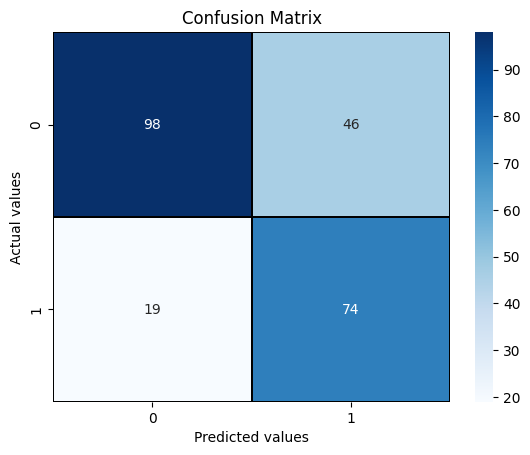

In [32]:
#confusion matrix
cm=confusion_matrix(y_test,prediction)
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',linewidth=0.3,linecolor='black')
plt.ylabel('Actual values')
plt.xlabel('Predicted values')
plt.title('Confusion Matrix')
plt.show()

From the confusion matrix above, it can be seen that when our model predicts 117 recipes as high traffic, we got 98 correct out of the 117.(i.e 83.8% correct prediction.)

In [33]:
#creating dataframe of features and corresponding coefficients
coef_df=pd.DataFrame()
coef_df['Features']=X.columns
coef_df['Coefficients']=np.round(final_model.coef_.ravel(),3)
coef_df

,Features,Coefficients
0,calories,-0.179
1,carbohydrate,-0.067
2,sugar,-0.072
3,protein,0.089
4,servings,-0.011
5,category_Beverages,2.618
6,category_Breakfast,0.853
7,category_Chicken,0.493
8,category_Chicken Breast,0.198
9,category_Dessert,-0.514


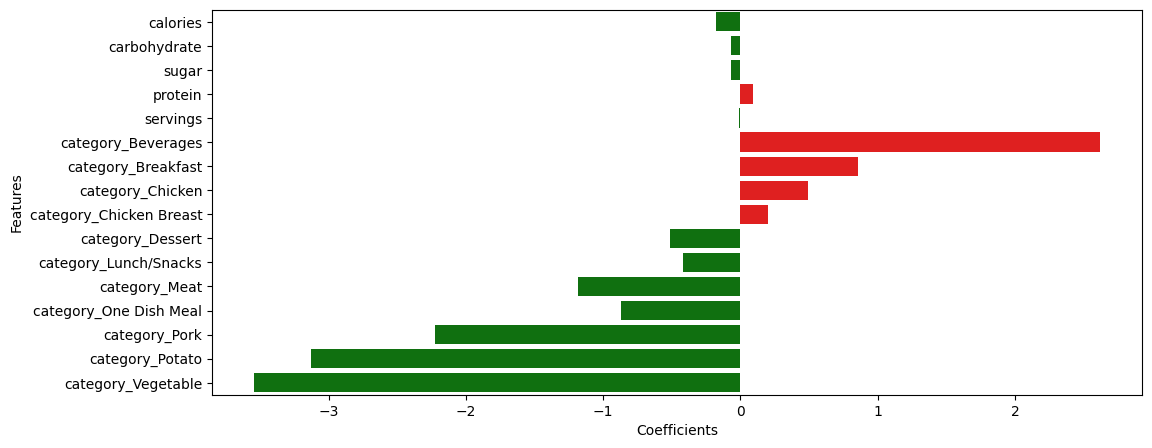

In [34]:
#selecting colors for barplot
bar_colors=[]
for i in coef_df['Coefficients']:
  if i<0:
    bar_colors.append('g')
  else:
    bar_colors.append('r')

#coefficients values barplot
plt.figure(figsize=(12,5))
sns.barplot(data=coef_df,y='Features',x='Coefficients',palette=bar_colors)
plt.show()

From the bar graph above, recipes that contributes significantly to high traffic have green bars, while the ones that led to low recipes have red bars.

## 5. Recommendation 

1. Getting more data will help our model to learn better and hence have better prediction. the available data have less than 1000 observations, and this is relatively small, so it is advisable to make use of more data next time.
2. Recipes containing these categories -Beverages, Breakfast, Chicken,Chicken Breast should be drastically 	reduced as they significantly lead to low traffic.Also,protein content should be moderated.
3. Recipes containing these categories -Vegetable, Pork, Potato,Meat,Dish Meal should be maintained and 	   increased as they significantly lead to high traffic and will bring about more subscription.